In [1]:
!pip install nilearn
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=1000) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_data().ravel())) 
- 1))
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, 
memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == b'F', dtype=np.int) # gives 1 for females and 0 for males
train_input = input_variables[:80]
train_output = output_variable[:80]

     |████████████████████████████████| 10.0 MB 7.7 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/oasis1



Downloaded 876371968 of 905208634 bytes (96.8%,    0.7s remaining) ...done. (22 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)



Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


1000 regions found in this atlas


In [2]:
y = list(range(80))
# take 100 bootstraps using random indices, that way don't have to zip them or anything, just use index to pick the input and output 
bootstraps_input = []
bootstraps_output = []
bootstraps_model_coef = []
# bootstarps_model = []
for i in range(100):
  indices = np.random.choice(y,80) #common to choose sample size the same as the original, so each bootstrap should contain 80 samples.
  bootstraps_input.append(train_input[indices]) 
  bootstraps_output.append(train_output[indices])
  model = L1_model = LogisticRegression(penalty='l1', solver='saga', C=1.0).fit(train_input[indices],train_output[indices])
  bootstraps_model_coef.append(model.coef_)
  # bootstarps_model.append(model)

bootstraps_input = np.array(bootstraps_input)
bootstraps_output = np.array(bootstraps_output)
bootstraps_model_coef = np.array(bootstraps_model_coef)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [3]:
bootstraps_model_coef = bootstraps_model_coef.squeeze()
bootstraps_model_coef = np.transpose(bootstraps_model_coef)
print(bootstraps_model_coef.shape)

(1000, 100)


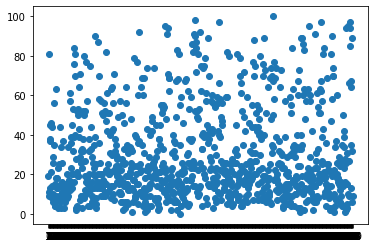

In [4]:
occur = []
for feature in bootstraps_model_coef:
  occur.append((feature != 0).sum())

plt.xticks(list(range(1000)))
plt.scatter(list(range(1000)),occur)